In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import random
from tqdm.notebook import tqdm
import IProgress
import ipywidgets

# PyTorch
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

# Scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Set random seed for reproducibility
SEED = 181
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Check if GPU is available
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


Train dataset shape: (19873, 3)
Validation dataset shape: (3039, 3)
Columns: ['time', 'snip', 'channel']

Sample training data:


,time,snip,channel
0,2024-01-01 00:00:00,"first of all, it feels like covid again but in...",FOXNEWSW
1,2024-01-01 00:03:00,to be a software drivenrganization where softw...,CSPAN
2,2024-01-01 00:15:00,you discuss the <b>power</b> <b>of</b> <em>ai<...,CSPAN2



Number of unique channels: 31

Class distribution in training set (top 10):


channel
CNNW         2725
FBC          1608
BBCNEWS      1576
BLOOMBERG    1441
CNBC         1319
MSNBCW       1141
FOXNEWSW     1106
CSPAN         913
CSPAN2        904
KNTV          842
Name: count, dtype: int64

Class imbalance (max/min): 68.125


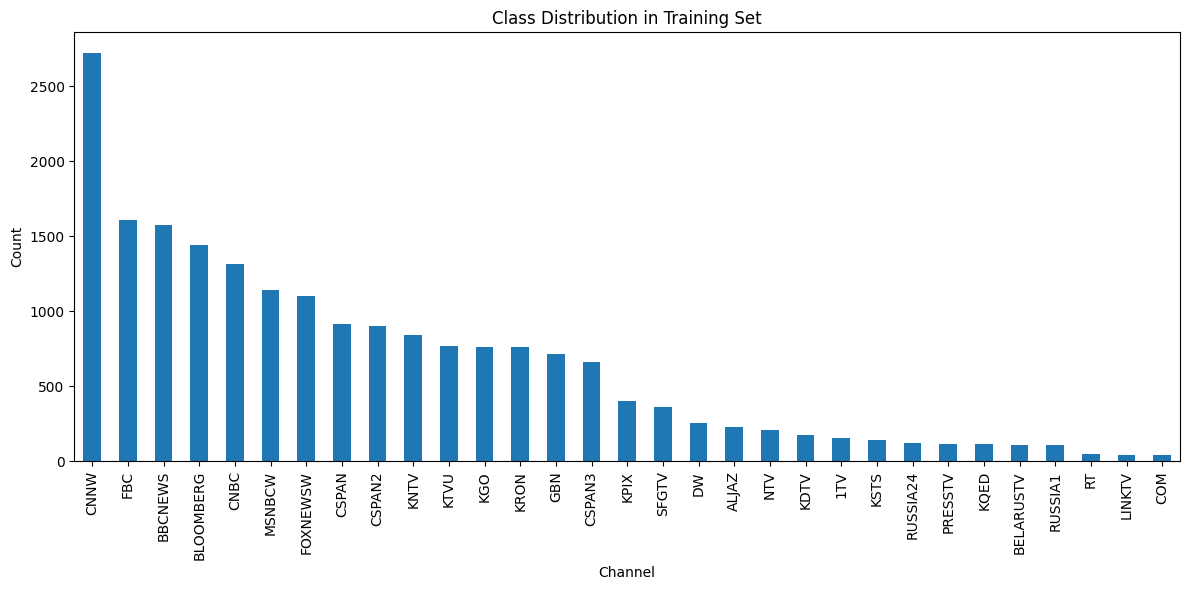


Sample text from CNNW:
<b>warning</b> <b>that</b> <em>ai</em> <b>will</b> <b>dramatically</b> alter the way the court operates.ng, quote, ai obviously has great potential to dramatically increase access to key information for lawyers and nonlawyers alike. just as obviously it risks invading privacy, interests and dehumani...


In [2]:
train_df = pd.read_csv('data/train.csv')
val_df = pd.read_csv('data/val.csv') 

# Display basic info
print(f"Train dataset shape: {train_df.shape}")
print(f"Validation dataset shape: {val_df.shape}")
print(f"Columns: {train_df.columns.tolist()}")

# Show a few samples from the sets
print("\nSample training data:")
display(train_df.head(3))

# Encode the labels consistently across datasets, important
label_encoder = LabelEncoder()
# Fit the encoder on all data to ensure consistent encoding
all_channels = pd.concat([
    train_df['channel'], 
    val_df['channel']
]).unique()
label_encoder.fit(all_channels)

# Apply encoding to each split
train_df['label'] = label_encoder.transform(train_df['channel'])
val_df['label'] = label_encoder.transform(val_df['channel'])

print(f"\nNumber of unique channels: {len(all_channels)}")

# Analyze class distribution in the training set
train_class_counts = train_df['channel'].value_counts()
print(f"\nClass distribution in training set (top 10):")
display(train_class_counts.head(10))

# Check class imbalance
max_count = train_class_counts.max()
min_count = train_class_counts.min()
imbalance_ratio = max_count / min_count
print(f"Class imbalance (max/min): {imbalance_ratio}")

# Visualize class distribution
plt.figure(figsize=(12, 6))
train_class_counts.plot(kind='bar')
plt.title('Class Distribution in Training Set')
plt.ylabel('Count')
plt.xlabel('Channel')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Sample snippet from the most common channel
most_common_channel = train_class_counts.index[0]
sample_text = train_df[train_df['channel'] == most_common_channel]['snip'].iloc[0]
print(f"\nSample text from {most_common_channel}:")
print(sample_text[:300] + "..." if len(sample_text) > 300 else sample_text)


In [4]:
def clean_html(text):
    if pd.isna(text):
        return text
    # Remove HTML tags
    clean = re.sub(r'<.*?>', '', str(text))
    # Remove extra whitespaces
    clean = re.sub(r'\s+', ' ', clean).strip()
    # Replace HTML entities
    clean = re.sub(r'&amp;', '&', clean)
    clean = re.sub(r'&lt;', '<', clean)
    clean = re.sub(r'&gt;', '>', clean)
    clean = re.sub(r'&quot;|&#34;', '"', clean)
    clean = re.sub(r'&apos;|&#39;', "'", clean)
    return clean

train_df = train_df.map(clean_html)
val_df = val_df.map(clean_html)


In [5]:
class Vocabulary:
    """Simple vocabulary class to convert words to indices"""
    
    def __init__(self, min_freq=2, max_size=50000):
        self.word2idx = {"<pad>": 0, "<unk>": 1}
        self.idx2word = {0: "<pad>", 1: "<unk>"}
        self.word_counts = {}
        self.min_freq = min_freq
        self.max_size = max_size
    
    def preprocess_text(self, text):
        # since we already cleaned tags above, we just lowercase and split
        if pd.isna(text):
            return []
        return text.lower().split()
    
    def build_vocab(self, texts):
        print("Building vocabulary...")
        
        # Count word frequencies
        for text in tqdm(texts):
            words = self.preprocess_text(text)
            
            for word in words:
                if word not in self.word_counts:
                    self.word_counts[word] = 0
                self.word_counts[word] += 1
        
        # Sort words by frequency in descending order
        sorted_words = sorted(self.word_counts.items(), key=lambda x: x[1], reverse=True)
        
        # Add words that meet minimum frequency to vocabulary
        idx = len(self.word2idx)
        for word, count in sorted_words:
            if count >= self.min_freq and idx < self.max_size:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1
        
        print(f"Vocabulary built with {len(self.word2idx)} words")
        print(f"Top 20 most frequent words:")
        for word, count in sorted_words[:20]:
            print(f"  {word}: {count}")
    
    def text_to_indices(self, text, max_length=None):
        words = self.preprocess_text(text)
        
        # Convert words to indices
        indices = []
        for word in words:
            if word in self.word2idx:
                indices.append(self.word2idx[word])
            else:
                indices.append(self.word2idx["<unk>"])
        
        # Truncate if needed
        if max_length is not None and len(indices) > max_length:
            indices = indices[:max_length]
            
        return indices

# Build vocabulary from the training data
vocab = Vocabulary(min_freq=2)
vocab.build_vocab(train_df['snip'].tolist())

# Test the vocabulary
sample_text = train_df['snip'].iloc[0]
sample_indices = vocab.text_to_indices(sample_text, max_length=100)
print(f"\nSample text: {sample_text[:100]}...")
print(f"Converted to indices: {sample_indices[:10]}...")
print(f"And back to words: {[vocab.idx2word[idx] for idx in sample_indices[:10]]}...")

Building vocabulary...


  0%|          | 0/19873 [00:00<?, ?it/s]

Vocabulary built with 50000 words
Top 20 most frequent words:
  the: 170647
  to: 101846
  and: 93838
  a: 80850
  of: 77478
  in: 58302
  is: 56650
  that: 48360
  you: 46175
  i: 37179
  for: 34898
  >>: 34275
  we: 33960
  it: 33309
  on: 30202
  with: 30185
  are: 27710
  this: 27178
  have: 21679
  ai: 21244

Sample text: first of all, it feels like covid again but instead of fact checking fauci, i need to fact check ai....
Converted to indices: [104, 6, 1396, 15, 1390, 42, 2572, 501, 25, 1114]...
And back to words: ['first', 'of', 'all,', 'it', 'feels', 'like', 'covid', 'again', 'but', 'instead']...
